In [17]:
# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [18]:
# 2. LOAD DATA
df = pd.read_csv('/content/ObesityDataSet.csv')

In [19]:
# 3. KONVERSI TIPE NUMERIK
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [20]:
# 4. EXPLORATORY DATA ANALYSIS (EDA)
print("Jumlah Baris & Kolom:", df.shape)
print("\nInfo Dataset:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplikasi Data:", df.duplicated().sum())
print("\nNilai Unik Tiap Kolom:\n", df.nunique())

Jumlah Baris & Kolom: (2111, 17)

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2089 non-null   float64
 1   Gender                          2102 non-null   object 
 2   Height                          2089 non-null   float64
 3   Weight                          2092 non-null   float64
 4   CALC                            2106 non-null   object 
 5   FAVC                            2100 non-null   object 
 6   FCVC                            2093 non-null   float64
 7   NCP                             2089 non-null   float64
 8   SCC                             2101 non-null   object 
 9   SMOKE                           2106 non-null   object 
 10  CH2O                            2096 non-null   float64
 11  family_history_with_overweight  2098 non-null  

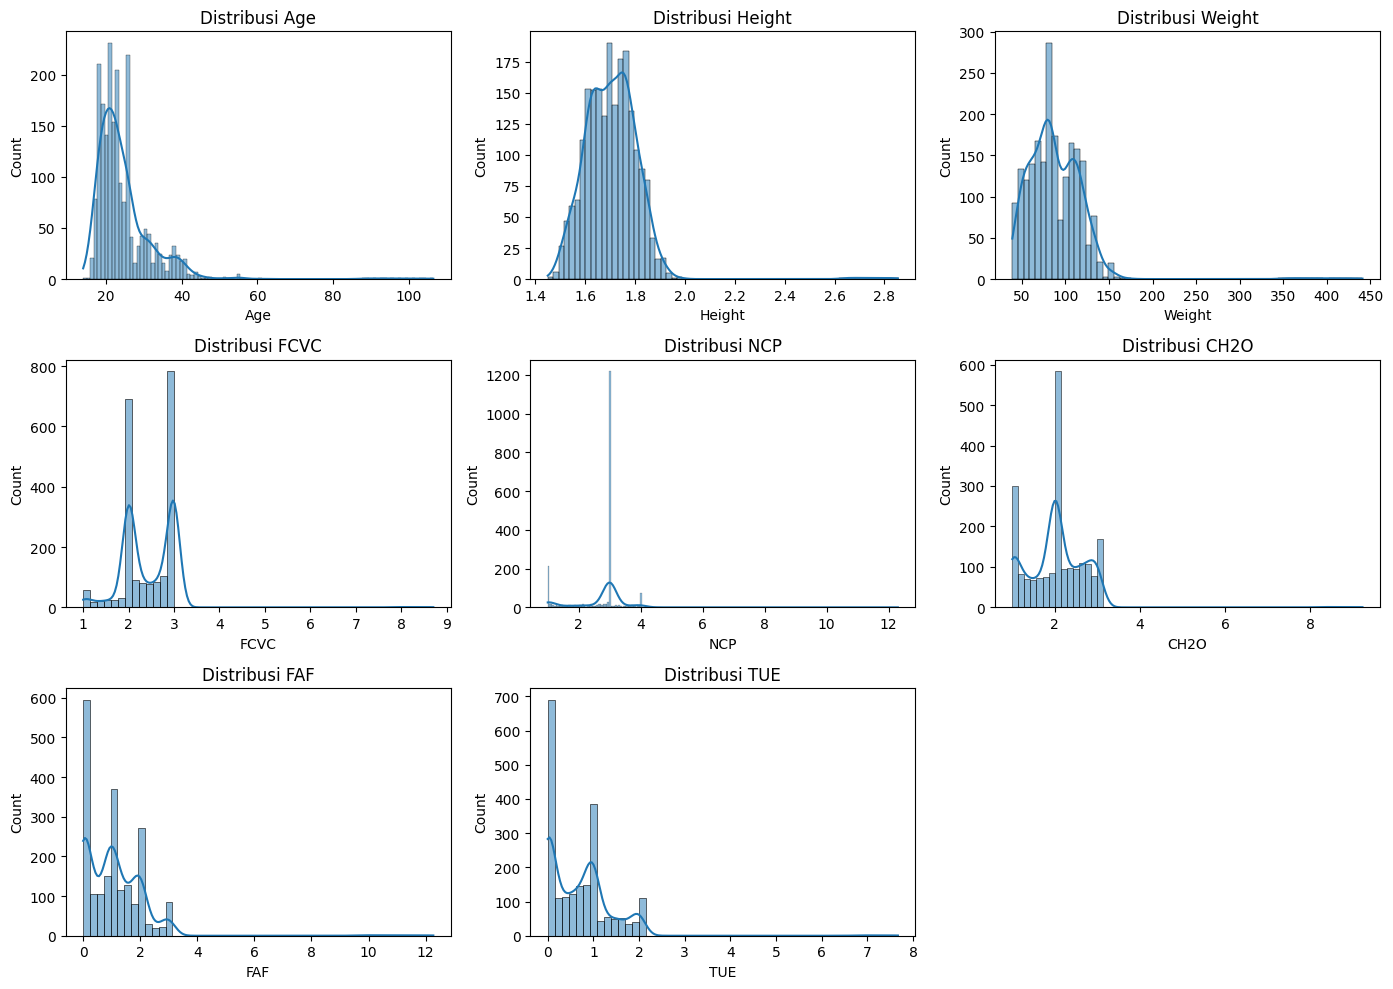

In [21]:
# Visualisasi distribusi numerik
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

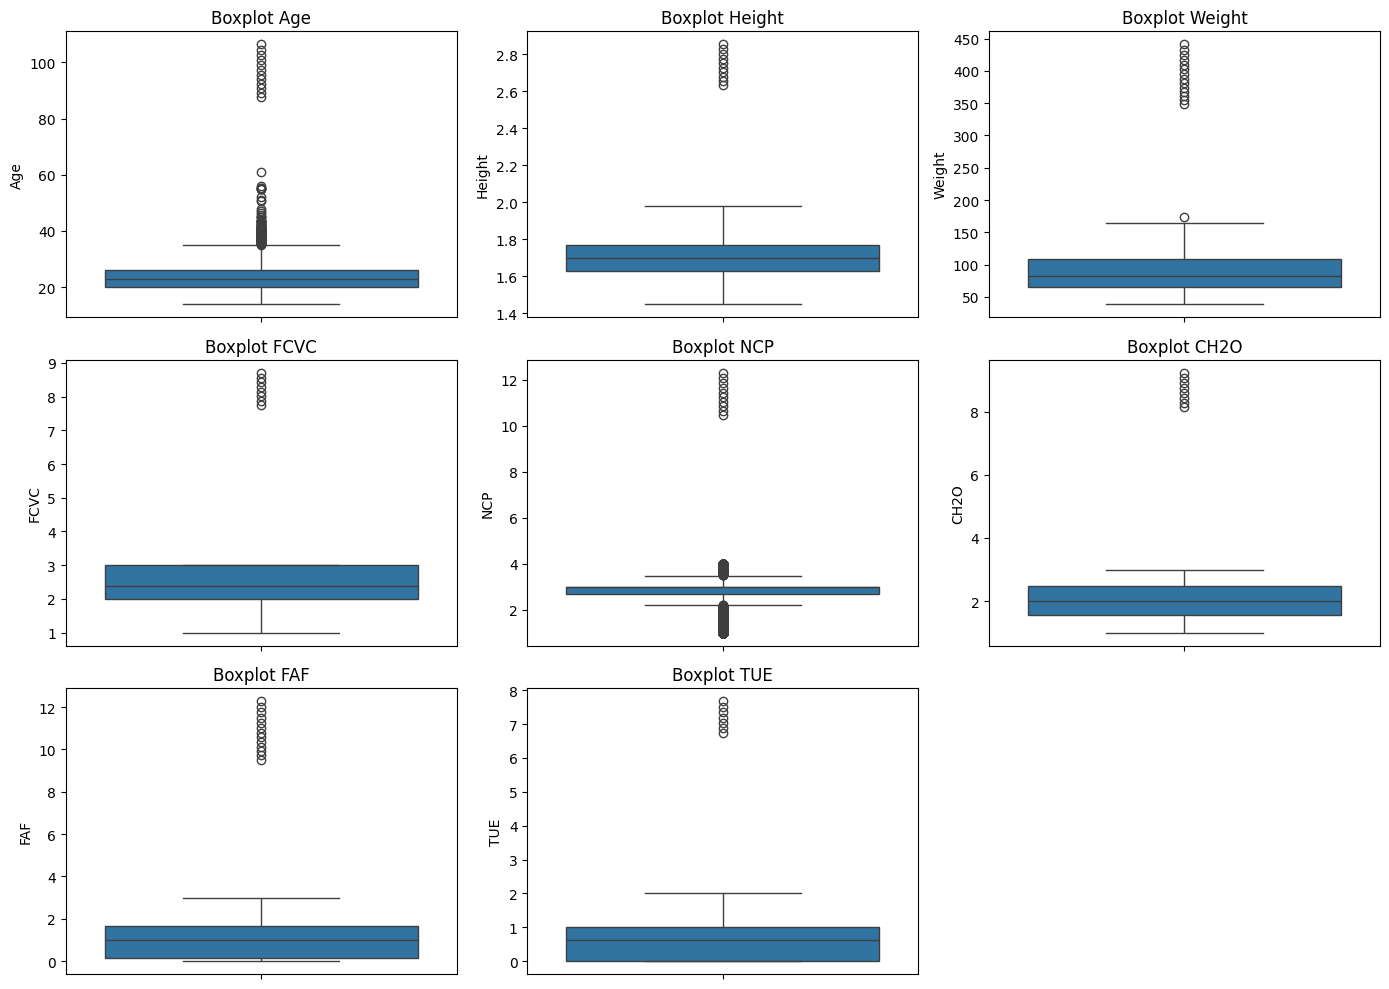

In [22]:
# Boxplot outlier
plt.figure(figsize=(14, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

In [23]:
# 5. PREPROCESSING DATA
df_clean = df.copy()

In [24]:
# Tangani missing values
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

In [25]:
# Hapus duplikat
df_clean = df_clean.drop_duplicates()

In [26]:
# Tangani outlier (IQR)
for col in numerical_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

In [27]:
# Label encoding untuk fitur kategorikal
label_enc_cols = ['Gender', 'CALC', 'FAVC', 'SCC', 'SMOKE', 'family_history_with_overweight', 'CAEC', 'MTRANS']
le = LabelEncoder()
for col in label_enc_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

In [28]:
# Pisahkan fitur dan label
X = df_clean.drop('NObeyesdad', axis=1)
y = df_clean['NObeyesdad']
y = le.fit_transform(y)  # Encode label target

In [29]:
# Tangani imbalance dengan SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [30]:
# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

nomor 3

In [31]:
# ===== PEMODELAN & EVALUASI =====
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(random_state=42)
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

In [35]:
# Loop training
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1 Score"].append(f1)
    print(f"=== {name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

=== Random Forest ===
Confusion Matrix:
 [[61  1  0  0  0  0  0]
 [ 0 63  0  0  0  0  0]
 [ 0  1 61  0  0  0  1]
 [ 0  0  0 63  0  0  0]
 [ 0  0  0  0 63  0  0]
 [ 0  9  0  0  0 54  0]
 [ 0  2  0  0  0  0 61]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.83      1.00      0.91        63
           2       1.00      0.97      0.98        63
           3       1.00      1.00      1.00        63
           4       1.00      1.00      1.00        63
           5       1.00      0.86      0.92        63
           6       0.98      0.97      0.98        63

    accuracy                           0.97       440
   macro avg       0.97      0.97      0.97       440
weighted avg       0.97      0.97      0.97       440



=== Logistic Regression ===
Confusion Matrix:
 [[62  0  0  0  0  0  0]
 [ 9 43  0  0  0 11  0]
 [ 0  0 49  4  0  2  8]
 [ 0  0  1 60  2  0  0]
 [ 0  0  0  0 62  1  0]


In [36]:
# Tampilkan hasil komparasi
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.968182   0.973199  0.968182  0.968704
1  Logistic Regression  0.829545   0.830475  0.829545  0.827581
2                  SVM  0.893182   0.897875  0.893182  0.894547


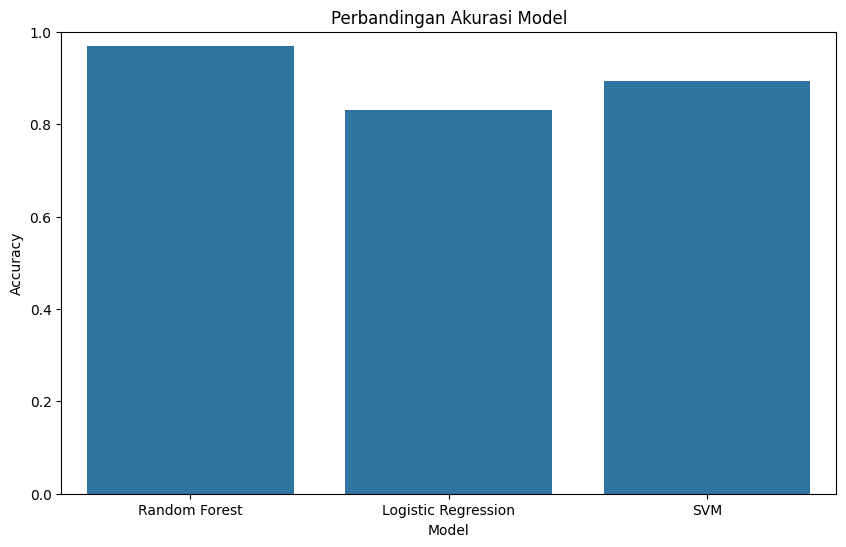

In [37]:
# Visualisasi performa
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1)
plt.show()